In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
mpl.rc('font', family='serif', size=11)
mpl.rc('savefig', bbox='tight')

import dtw
import worg

make_fname_safe = lambda s: s.lower().replace(' ', '-')

/home/scopatz/miniconda/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/home/scopatz/miniconda/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)
/home/scopatz/miniconda/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.enrichment is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
T = 50
seed = 424242
verbose = True
f = 90 * (1.01**np.arange(T))  # 1% growth
g0 = np.zeros(T, dtype='f8')    # zero production
N = np.asarray(np.ceil(4*(1.01)**np.arange(T)), dtype=int)

DTW
======

In [3]:
def display_dwt(dist, cost, path, xname, yname, offset=2016, vmax=None):
    fig = plt.figure(figsize=(8, 6))
    extent = (offset, offset+cost.shape[1], offset, offset+cost.shape[0])
    plt.imshow(cost[::-1], cmap='viridis', extent=extent, vmin=0.0, vmax=vmax)
    u = offset + np.concatenate([path, np.array([[cost.shape[1]], [cost.shape[0]]])], axis=1)
    plt.plot(u[1], u[0], 'w-')
    plt.axis(extent)
    cb = plt.colorbar()
    cb.set_label('Cost [GWe]', rotation=-90, va='bottom')
    plt.xlabel('time [year]')
    plt.ylabel('time [year]')
    fname = 'cost-{0}-to-{1}'.format(make_fname_safe(xname), make_fname_safe(yname))
    plt.savefig(fname + '.png')
    plt.savefig(fname + '.eps')
    print('Warping between {0} and {1}:'.format(xname, yname))
    print('  Distance is ', dist)

Warping between Demand and Production:
  Distance is  0.755990232857


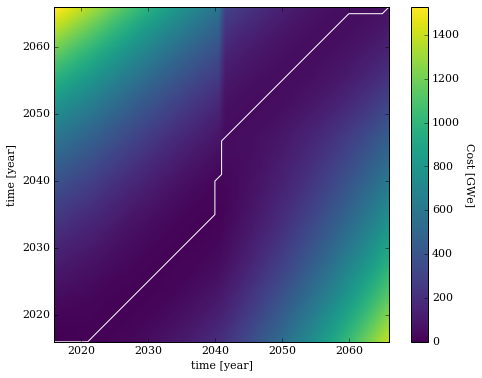

In [4]:
p = np.empty(T, dtype='f8')
p[:T//2] = f[:T//2] * 0.95
p[T//2:] = f[T//2:] * 1.05
dist, cost, path = dtw.dtw(f[:,np.newaxis], p[:,np.newaxis])
display_dwt(dist, cost, path, 'Demand', 'Production')

GP
=======

In [5]:
def model_plot(t, y, yerr, tpred, mu, std, title=None, ymax=None):
    fig = plt.figure(figsize=(8, 8))
    #plt.errorbar(t, y, yerr, fmt='r.', label='traing data')
    plt.plot(t, y, 'r.', label='traing data')
    plt.plot(tpred, mu, 'k-', label='model')
    plt.fill_between(tpred, mu - 2*std, mu + 2*std, color='gray')
    ax = plt.axis()
    plt.axis([tpred[0], tpred[-1], 0.0, ymax or ax[3]])
    plt.legend(loc=0)
    plt.xlabel('time [year]')
    plt.ylabel('Power Production [GWe]')
    if title:
        plt.title(title)
    fbase = 'gwe-model-' + (title or '').lower().replace(' ', '-')
    plt.savefig(fbase + '.eps')
    plt.savefig(fbase + '.png')

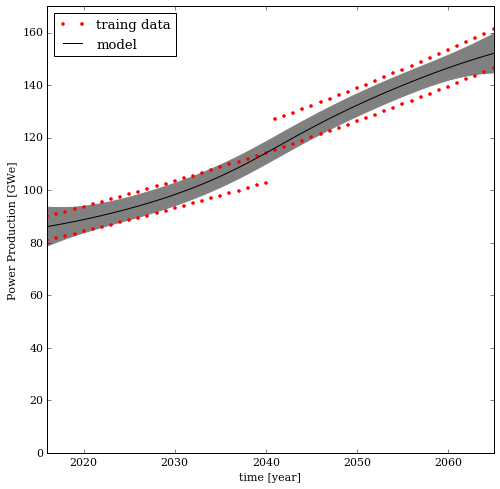

In [6]:
tol = 1e-1
q = np.empty(T, dtype='f8')
q[:T//2] = f[:T//2] * 0.9
q[T//2:] = f[T//2:] * 1.1
gp, x, y = worg.gp_gwe([N, N], [f, q], T, tol, N)
mu, cov = gp.predict(y, x[:T])
std = np.sqrt(np.diag(cov))
model_plot(x[:,0]+2016, y, 0.0, x[:T,0] + 2016, mu, std)

Optimizations
========

In [7]:
T = 20

def run_percent_growth(rate, f0=90.0, N0=10, T=T, seed=seed, verbose=verbose, **kwargs):
    r = 1.0 + (rate/100.0)
    tgrid = np.arange(T)
    f = f0 * (r**tgrid)
    N = np.asarray(np.ceil(N0*(r**tgrid)), dtype=int)
    state = worg.optimize(f, N, seed=seed, verbose=verbose, **kwargs)
    return state

In [8]:
%time state0sto = run_percent_growth(0, MAX_S=20, method_0='stochastic')

Simulation 3
------------
SimId 36d21d29-3e6c-46bb-8d2b-6c9360d2f813
hyperparameters: [ 8.2593187   4.52500623]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.0264618396759033 sec
Simulation time: 0.0 min 4.185940980911255 sec
D_s: 3.1791666666666365
D: [3.1791666666666365, 9.8083333333332412]

Simulation 4
------------
SimId 7f7d34ac-496b-4d85-818c-2e24bd7f1af0
hyperparameters: [ 5.08301056  3.40378271]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 0.9764587879180908 sec
Simulation time: 0.0 min 5.202778577804565 sec
D_s: 5.937499999999323
D: [3.1791666666666365, 5.9374999999993232]

Simulation 5
------------
SimId 76657e01-a72c-42d5-98b7-bdb36c94c0ad
hyperparameters: [ 4.66739622  2.47710559]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.367086410522461 sec
Simulation time: 0.0 min 5.047498941421509 sec
D_s: 2.0187499999999607
D: [2.0187499999999607, 3.1

In [9]:
%time state0inn = run_percent_growth(0, MAX_S=20, method_0='inner-prod')

Simulation 3
------------
SimId 44305811-93ee-4f7f-8775-cdc8b5284bf7
hyperparameters: [ 8.2593187   4.52500623]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.4061014652252197 sec
Simulation time: 0.0 min 4.558087348937988 sec
D_s: 3.4541666666666964
D: [3.4541666666666964, 9.8083333333332412]

Simulation 4
------------
SimId d4e8afa6-0321-4770-9c53-507fe26b6248
hyperparameters: [ 4.96939389  3.35689812]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.3895738124847412 sec
Simulation time: 0.0 min 4.530719518661499 sec
D_s: 2.1250000000000298
D: [2.1250000000000298, 3.4541666666666964]

Simulation 5
------------
SimId 483de10a-4d53-4284-a04b-c0bac3cc143d
hyperparameters: [ 3.13957111  1.93044129]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.377549409866333 sec
Simulation time: 0.0 min 4.897815227508545 sec
D_s: 2.002083333333408
D: [2.0020833333334078, 2.1

In [10]:
%time state0all = run_percent_growth(0, MAX_S=20, method_0='all')

Simulation 3
------------
SimId c769af37-1714-47c7-a7c2-bd372aa62761
hyperparameters: [ 8.2593187   4.52500623]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 1.3513574600219727 sec
Simulation time: 0.0 min 4.043424129486084 sec
D_s: 3.4541666666666964
D: [3.4541666666666964, 9.8083333333332412]

Simulation 4
------------
SimId f0dd2445-744e-4dd0-acd5-9f9e09bf3d6f
hyperparameters: [ 4.96939389  3.35689812]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 1.356823205947876 sec
Simulation time: 0.0 min 4.952929973602295 sec
D_s: 2.1250000000000298
D: [2.1250000000000298, 3.4541666666666964]

Simulation 5
------------
SimId c85a2cac-01a3-440c-8571-8f2a0a6555a5
hyperparameters: [ 3.13957111  1.93044129]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.2111539840698242 sec
Simulation time: 0.0 min 5.7546844482421875 sec
D_s: 3.9145833333327347
D: [2.1250000000000298, 3.4541666666666

In [11]:
%time state1sto = run_percent_growth(1, MAX_S=20, method_0='stochastic')

Simulation 3
------------
SimId edf74307-ed4f-4895-b6fe-992587cc67ad
hyperparameters: [ 8.58728406  4.5605898 ]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.291839361190796 sec
Simulation time: 0.0 min 4.23829460144043 sec
D_s: 5.952819776625992
D: [5.9528197766259918, 14.30609232162578]

Simulation 4
------------
SimId b0c93856-ebfb-402e-956c-87b93131fc79
hyperparameters: [ 5.31310779  3.62122666]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.187896728515625 sec
Simulation time: 0.0 min 4.629993438720703 sec
D_s: 1.0913573738881053
D: [1.0913573738881053, 5.9528197766259918]

Simulation 5
------------
SimId b9600714-fd63-4f9e-a67b-cd1960efb733
hyperparameters: [ 4.45135636  2.60789788]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.122359037399292 sec
Simulation time: 0.0 min 5.129270792007446 sec
D_s: 2.701777228550989
D: [1.0913573738881053, 2.701777

In [12]:
%time state1inn = run_percent_growth(1, MAX_S=20, method_0='inner-prod')

Simulation 3
------------
SimId e0448eb5-4cee-4381-9dcb-5848374d5695
hyperparameters: [ 8.58728406  4.5605898 ]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.46196794509887695 sec
Simulation time: 0.0 min 4.571685075759888 sec
D_s: 1.4707812247893888
D: [1.4707812247893888, 14.30609232162578]

Simulation 4
------------
SimId 36b1a754-11da-4b6c-bea4-895af9491646
hyperparameters: [ 5.65715799  3.99432655]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.4618072509765625 sec
Simulation time: 0.0 min 4.825010538101196 sec
D_s: 0.8522307813314448
D: [0.85223078133144481, 1.4707812247893888]

Simulation 5
------------
SimId 629e9582-82ea-41bf-8b32-038714139966
hyperparameters: [ 2.6667925   1.35406172]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.5278966426849365 sec
Simulation time: 0.0 min 5.691087007522583 sec
D_s: 1.3538143911818423
D: [0.85223078133144481,

In [13]:
%time state1all = run_percent_growth(1, MAX_S=20, method_0='all')

Simulation 3
------------
SimId 197cd3ca-ce5b-4aec-9d91-1153ae4714ff
hyperparameters: [ 8.58728406  4.5605898 ]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 1.6284997463226318 sec
Simulation time: 0.0 min 4.612561225891113 sec
D_s: 1.4707812247893888
D: [1.4707812247893888, 14.30609232162578]

Simulation 4
------------
SimId 2ba1d608-ca75-4d36-80eb-de41f0cb42bd
hyperparameters: [ 5.65715799  3.99432655]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 1.7384803295135498 sec
Simulation time: 0.0 min 5.4313764572143555 sec
D_s: 0.8522307813314448
D: [0.85223078133144481, 1.4707812247893888]

Simulation 5
------------
SimId c9f3f0d4-9e20-486f-a11b-5eaea95d94ba
hyperparameters: [ 2.6667925   1.35406172]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.0597541332244873 sec
Simulation time: 0.0 min 5.937432050704956 sec
D_s: 3.8248014087558717
D: [0.85223078133144481, 1.47078122478

In [14]:
%time state2sto = run_percent_growth(2, MAX_S=20, method_0='stochastic')

Simulation 3
------------
SimId a457ad8d-c7d8-42b0-b039-86a2de58298a
hyperparameters: [ 8.80224829  4.55118758]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.1811833381652832 sec
Simulation time: 0.0 min 3.918757915496826 sec
D_s: 14.58949871423159
D: [14.58949871423159, 19.423248714231484]

Simulation 4
------------
SimId 9914c5ed-4e22-4687-842c-ab348fd20216
hyperparameters: [ 4.8998217   3.37256138]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.2766871452331543 sec
Simulation time: 0.0 min 4.77653694152832 sec
D_s: 5.198902042055451
D: [5.198902042055451, 14.58949871423159]

Simulation 5
------------
SimId 63a7e863-c970-4a4c-8955-aacdd1108ad2
hyperparameters: [ 4.15982337  2.23060572]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.3220744132995605 sec
Simulation time: 0.0 min 5.305983066558838 sec
D_s: 2.7651476075241215
D: [2.7651476075241215, 5.19890

In [15]:
%time state2inn = run_percent_growth(2, MAX_S=20, method_0='inner-prod')

Simulation 3
------------
SimId 854896ee-20a0-4073-bd38-d34aeac85b1e
hyperparameters: [ 8.80224829  4.55118758]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.5129289627075195 sec
Simulation time: 0.0 min 4.273391485214233 sec
D_s: 2.690879049301638
D: [2.6908790493016381, 19.423248714231484]

Simulation 4
------------
SimId 4031db25-ea9e-480f-ae6d-4ed1c07dde4e
hyperparameters: [ 5.75445891  3.77715026]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.5097877979278564 sec
Simulation time: 0.0 min 4.650067090988159 sec
D_s: 2.826056990988357
D: [2.6908790493016381, 2.8260569909883571]

Simulation 5
------------
SimId b4764f3f-1398-4931-ba8a-da01ddb9f623
hyperparameters: [ 3.44085725  1.65251327]
Estimate method is 'inner-prod'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.515233039855957 sec
Simulation time: 0.0 min 5.245330095291138 sec
D_s: 3.4486516004432017
D: [2.6908790493016381, 2.82

In [16]:
%time state2all = run_percent_growth(2, MAX_S=20, method_0='all')

Simulation 3
------------
SimId 6028d6c6-2eee-4181-8af6-45568d2f2161
hyperparameters: [ 8.80224829  4.55118758]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 1.5688037872314453 sec
Simulation time: 0.0 min 4.249006509780884 sec
D_s: 2.690879049301638
D: [2.6908790493016381, 19.423248714231484]

Simulation 4
------------
SimId 2b6c2ad4-d508-4859-ba34-05fb0016c4ad
hyperparameters: [ 5.75445891  3.77715026]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 1.688216209411621 sec
Simulation time: 0.0 min 4.86178731918335 sec
D_s: 2.826056990988357
D: [2.6908790493016381, 2.8260569909883571]

Simulation 5
------------
SimId c79c727f-1240-4bb3-abc6-30bc393b9f4d
hyperparameters: [ 3.44085725  1.65251327]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 1.1481409072875977 sec
Simulation time: 0.0 min 5.475087642669678 sec
D_s: 0.8483124109832669
D: [0.84831241098326693, 2.6908790493016381

In [17]:
def convergence_plot(states, linestyles, labels, r):
    for state, ls, label in zip(states, linestyles, labels):
        x = np.arange(1, state['s'] + 1)
        D_s = state['D_s']
        y = np.fromiter((min(D_s[:i]) for i in x), dtype='f8', count=len(x))
        plt.semilogy(x, y, linestyle=ls, color='gray', label=label)
        smask = np.fromiter((w == 'stochastic' for w in state['winner_s']), 
                            dtype='bool', count=len(x))
        if np.any(smask):
            plt.semilogy(x[smask], y[smask], linestyle='None', marker='$S$')
        imask = np.fromiter((w == 'inner-prod' for w in state['winner_s']), 
                            dtype='bool', count=len(x))
        if np.any(imask):
            plt.semilogy(x[imask], y[imask], linestyle='None', marker='$I$')
        amask = np.fromiter((w == 'all' for w in state['winner_s']), 
                            dtype='bool', count=len(x))
        if np.any(amask):
            plt.semilogy(x[amask], y[amask], linestyle='None', marker='$A$')
    plt.axis([1, 20, 0.1, 100])
    plt.grid()
    plt.legend(loc=0)
    plt.xlabel('Simulation $s$')
    plt.ylabel('Minimum Distance, $d(f, g_s)$ [GWe]')
    plt.title('{}% Growth'.format(r))
    fname = 'converge-{}per'.format(r)
    plt.savefig(fname + '.eps')
    plt.savefig(fname + '.png')

In [18]:
linestyles = ['--', 'dotted', '-']
labels = ['stochastic', 'inner-prod', 'all']

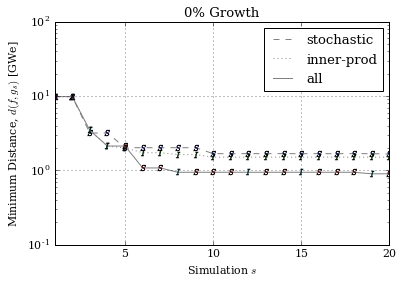

In [19]:
convergence_plot([state0sto, state0inn, state0all], linestyles, labels, 0)

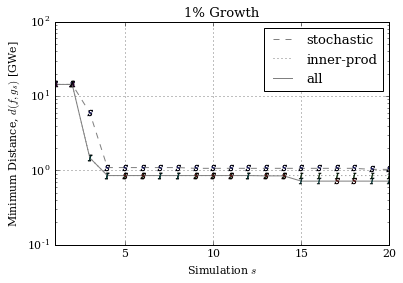

In [20]:
convergence_plot([state1sto, state1inn, state1all], linestyles, labels, 1)

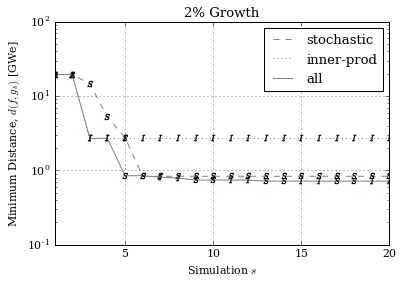

In [21]:
convergence_plot([state2sto, state2inn, state2all], linestyles, labels, 2)

In [40]:
def demand_product(states, title):
    rates = [0, 1, 2]
    colors = ['k', 'green', 'purple']
    for state, color, rate in zip(states, colors, rates):
        f = state['f']
        g = state['G'][0]
        h = state['G'][1]
        t = 2016 + np.arange(len(g))
        plt.plot(t, f, linestyle='--', color=color)
        plt.plot(t, g, linestyle='-', color=color, label='{}% growth'.format(rate))
        plt.plot(t, h, linestyle=':', color=color)
    plt.legend(loc=0)
    plt.axis([2016, 2015+T, 80, 150])
    plt.xlabel('time [year]')
    plt.ylabel('Power [GWe]')
    plt.title(title + ' Method')
    fname = 'demand-product-{}'.format(make_fname_safe(title))
    plt.savefig(fname + '.eps')
    plt.savefig(fname + '.png')

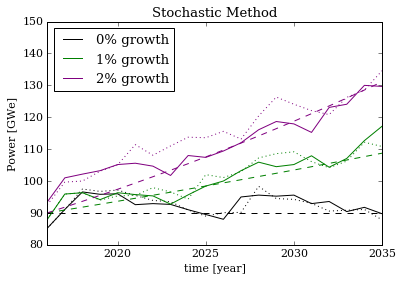

In [44]:
demand_product([state0sto, state1sto, state2sto], 'Stochastic')

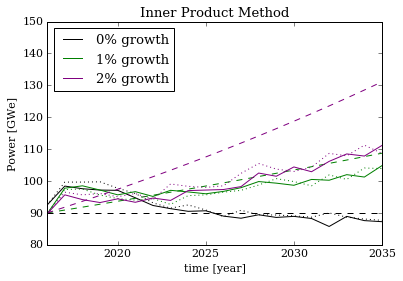

In [45]:
demand_product([state0inn, state1inn, state2inn], 'Inner Product')

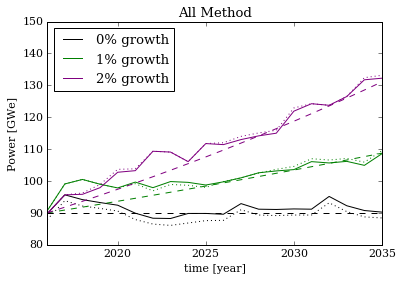

In [46]:
demand_product([state0all, state1all, state2all], 'All')

In [26]:
%time state0all5 = run_percent_growth(0, T=5, MAX_S=20, method_0='all')

Simulation 3
------------
SimId e031030d-a8a3-449c-acf4-40b5e70b1f90
hyperparameters: [ 5.52121741  2.56745438]
Estimate method is 'all'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 0.08427882194519043 sec
Simulation time: 0.0 min 2.6550135612487793 sec
D_s: 1.108378905774412
D: [1.108378905774412, 1.7250455724411942]

Simulation 4
------------
SimId e73921d0-ff8b-4845-95b6-27351e0b21ab
hyperparameters: [ 2.04823028 -3.99452032]
Estimate method is 'all'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 0.12698030471801758 sec
Simulation time: 0.0 min 2.9440243244171143 sec
D_s: 1.1667122391074407
D: [1.108378905774412, 1.1667122391074407]

Simulation 5
------------
SimId 207b3dc4-9456-4184-8f89-ce5f6a5de1d5
hyperparameters: [ 2.06091185 -5.12150071]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 0.12938356399536133 sec
Simulation time: 0.0 min 3.3418452739715576 sec
D_s: 2.950045572440673
D: [1.108378905774412, 1.166712239107

In [27]:
%time state0all10 = run_percent_growth(0, T=10, MAX_S=20, method_0='all')

Simulation 3
------------
SimId 80341530-1bf3-4e91-b416-bccbffe30544
hyperparameters: [ 6.69465397  3.16909857]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.2497396469116211 sec
Simulation time: 0.0 min 3.2706189155578613 sec
D_s: 2.316666666666761
D: [2.316666666666761, 4.1666666666667309]

Simulation 4
------------
SimId f005a958-04f1-4dde-8a77-4f58f7790c56
hyperparameters: [ 3.51804711  2.08594765]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.29625892639160156 sec
Simulation time: 0.0 min 3.3978443145751953 sec
D_s: 2.0166666666667026
D: [2.0166666666667026, 2.316666666666761]

Simulation 5
------------
SimId 003f9790-90c7-4aa8-a26f-727de799b142
hyperparameters: [ 2.61726001  1.51751385]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 0.20598220825195312 sec
Simulation time: 0.0 min 3.7861480712890625 sec
D_s: 8.545833333332588
D: [2.0166666666667026, 2.316666666666

In [28]:
%time state0all15 = run_percent_growth(0, T=15, MAX_S=20, method_0='all')

Simulation 3
------------
SimId 72b26459-1d09-46a3-bfb2-f96e11b02518
hyperparameters: [ 7.48416948  4.03295493]
Estimate method is 'all'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 0.5958201885223389 sec
Simulation time: 0.0 min 3.4784042835235596 sec
D_s: 2.6083333333332606
D: [2.6083333333332606, 6.9472222222221687]

Simulation 4
------------
SimId ddee2b93-66c8-41fd-bfdc-4ebe0d83acd3
hyperparameters: [ 4.67866951  3.29229317]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 0.6298015117645264 sec
Simulation time: 0.0 min 3.958664655685425 sec
D_s: 2.563888888888668
D: [2.5638888888886679, 2.6083333333332606]

Simulation 5
------------
SimId 1139cc91-03d8-49cd-baeb-f7382098c689
hyperparameters: [ 3.88835507  2.54352145]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 0.48282408714294434 sec
Simulation time: 0.0 min 4.270829677581787 sec
D_s: 5.741666666666015
D: [2.5638888888886679, 2.6083333333332

In [31]:
%time state0all50 = run_percent_growth(0, T=50, MAX_S=20, method_0='all')

Simulation 3
------------
SimId 9bb2ae1d-0ad5-41b0-8526-65c04e5f183e
hyperparameters: [ 9.70060326  5.55715944]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 17.21244239807129 sec
Simulation time: 0.0 min 8.669551610946655 sec
D_s: 2.0916666666667134
D: [2.0916666666667134, 26.146666666666629]

Simulation 4
------------
SimId c240d004-406f-4940-8fcd-f3bd43cd5a25
hyperparameters: [ 6.93964877  5.11160459]
Estimate method is 'all'
Estimate winner is 'inner-prod'
Estimate time:   0.0 min 20.178144216537476 sec
Simulation time: 0.0 min 8.170564889907837 sec
D_s: 3.21583333333294
D: [2.0916666666667134, 3.2158333333329399]

Simulation 5
------------
SimId 25b575ff-9496-4c87-be1d-090d9ffa671f
hyperparameters: [ 3.97217822  2.63561702]
Estimate method is 'stochastic'
Estimate winner is 'stochastic'
Estimate time:   0.0 min 14.371109962463379 sec
Simulation time: 0.0 min 9.211265802383423 sec
D_s: 3.166666666666727
D: [2.0916666666667134, 3.1666666666667269]

In [32]:
def time_horizon_plot(states):
    x, y = [], []
    for state in states:
        x.append(state['T'])
        y.append(state['D'][0])
    plt.plot(x, y, 'k-')

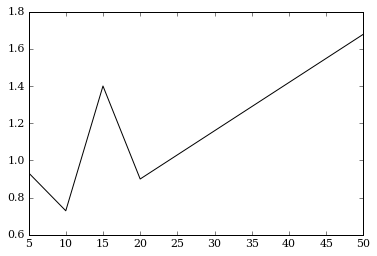

In [33]:
time_horizon_plot([state0all5, state0all10, state0all15, state0all, state0all50])